# Useful to test syntaxes, data, structure before adding them to scripts

In [1]:
import warnings
warnings.simplefilter(action='ignore')

import functools
import argparse
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter
from scipy.stats import gamma
import os
import time
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchnet as tnt
from sklearn.neighbors import NearestNeighbors
import gc

import torch.nn as nn
from scipy.special import digamma, polygamma

import matplotlib
# Weird behavior: loading twice in cell appears to remove an elsewise occuring error.
for i in range(2):
    try:
        matplotlib.use('TkAgg')  # rerun this cell if an error occurs.
    except:
        print("!")
import matplotlib.pyplot as plt


import pickle
from torch_scatter import scatter_max, scatter_mean

print(torch.cuda.is_available())
np.random.seed(42)
torch.cuda.empty_cache()
print("Everything is imported")

False
Everything is imported


In [2]:
%matplotlib inline
import matplotlib.colors as clr

In [5]:
from osgeo import gdal
import sys
import os
sys.path.append("/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/")
from config import args
from utils.useful_functions import create_new_experiment_folder, print_stats

Dataset folder in use: /home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/data/
Arguments were imported in DEV mode


In [6]:
# create_new_experiment_folder(args)  # new paths are added to args
# work with previous inference results
args.stats_path = "/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/experiments/RESULTS_3_strata/only_stratum/DEV/inference/2021-06-08_17h51m52s/"
tiff_folder_path = os.path.join(args.stats_path, "img/rasters/004000715-5-18/")
input_file_list = os.path.join(tiff_folder_path, "rasters_paths.txt")

# with open(input_file_list, "w") as f:
#     for fname in os.listdir(tiff_folder_path):
#         path = os.path.join(tiff_folder_path, fname)
#         f.write(path)
#         f.write("\n")

In [7]:
# GDAL python APIs doc: https://gdal.org/python/index.html
# PixelFunction in python - doc : https://gdal.org/drivers/raster/vrt.html#examples
# To add python function in vrt file: https://github.com/aerospaceresearch/DirectDemod/blob/1435456bbe4073faec2e812122be03e7094a582c/directdemod/merger.py#L29

tiff_paths = [
    os.path.join(tiff_folder_path, fname) for fname in os.listdir(tiff_folder_path) if fname.endswith(".tif")
]

vrt_raster_fname = os.path.join(tiff_folder_path, "merged_raster.vrt")
raster_fname = vrt_raster_fname.replace(".vrt",".tif")

vrt_options = gdal.BuildVRTOptions(
    resolution="highest",
    outputBounds=None,
    xRes=None,
    yRes=None,
    targetAlignedPixels=None,
    separate=None,
    bandList=None,
    addAlpha=None,
    resampleAlg=None,
    outputSRS=None,
    allowProjectionDifference=False,
    srcNodata=None,  # Carefull, perhaps to be specified
    VRTNodata=None,
    hideNodata=None,
    callback=None,
    callback_data=None,
)

vrt = gdal.BuildVRT(vrt_raster_fname, tiff_paths, options=vrt_options)
vrt.FlushCache()  # needed elsewise vrt not saved, see

In [8]:
use_custom_average = True
pixelfunction_str ="""
import numpy as np
def average(in_ar, out_ar, xoff, yoff, xsize, ysize, raster_xsize,raster_ysize, buf_radius, gt, **kwargs):
    div = np.zeros(in_ar[0].shape)
    for i in range(len(in_ar)):
        div += (in_ar[i] != 0)
    div[div == 0] = 1
    
    y = np.sum(in_ar, axis = 0, dtype = 'uint16')
    y = y / div
    
    np.clip(y,0,255, out = out_ar)
"""
# v2
pixelfunction_str = """
import numpy as np
def average(in_ar, out_ar, xoff, yoff, xsize, ysize, raster_xsize,raster_ysize, buf_radius, gt, **kwargs):
        x = np.ma.masked_equal(in_ar, -3.4e+38)
        np.nanmean(x, axis = 0,out = out_ar, dtype = 'float64')
        mask = np.all(x.mask,axis = 0)
        out_ar[mask]=-3.4e+38
"""

# tst
pixelfunction_str = """
import numpy as np

def average(in_ar, out_ar, xoff, yoff, xsize, ysize, raster_xsize,raster_ysize, buf_radius, gt, **kwargs):
    x = np.ma.masked_greater(in_ar, 1)
    np.mean(x, axis = 0,out = out_ar, dtype = 'uint8')
    mask = np.all(x.mask,axis = 0)
    out_ar[mask]=255

"""

print(pixelfunction_str)


import numpy as np

def average(in_ar, out_ar, xoff, yoff, xsize, ysize, raster_xsize,raster_ysize, buf_radius, gt, **kwargs):
    x = np.ma.masked_greater(in_ar, 1)
    np.mean(x, axis = 0,out = out_ar, dtype = 'uint8')
    mask = np.all(x.mask,axis = 0)
    out_ar[mask]=255




In [9]:
"""inserts pixel-function 'average' into vrt file named 'filename'
Args:
    filename (:obj:`string`): name of file, into which the function will be inserted
    resample_name (:obj:`string`): name of resampling method
"""

header = """  <VRTRasterBand dataType="Byte" band="1" subClass="VRTDerivedRasterBand">"""
contents = f"""
<PixelFunctionType>add</PixelFunctionType>
<PixelFunctionLanguage>Python</PixelFunctionLanguage>
<PixelFunctionCode><![CDATA[{pixelfunction_str}]]>
</PixelFunctionCode>
"""

# rewrite vrt file
if use_custom_average:
    lines = open(vrt_raster_fname, 'r').readlines()
    lines[3] = header  # FIX ME: 3 is a hand constant
    lines.insert(4, contents)
    with open(vrt_raster_fname, 'w') as f:
        f.write("".join(lines))

In [22]:
# create the tif file to check results !
vrt_ds = gdal.Open(vrt_raster_fname, gdal.GA_ReadOnly)
ds = gdal.Translate(raster_fname, vrt_ds)
ds = None

In [21]:
# test
os.path.isfile(vrt_raster_fname),os.path.isfile(raster_fname)

(True, False)

In [12]:
# !gdalinfo "$vrt_raster_fname"

In [13]:
vrt_raster_fname

'/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/experiments/RESULTS_3_strata/only_stratum/DEV/inference/2021-06-08_17h51m52s/img/rasters/004000715-5-18/merged_raster.vrt'

In [14]:
# ! gdal_translate --config GDAL_VRT_ENABLE_PYTHON YES -colorinterp red "$vrt_raster_fname" "$raster_fname"

# Create fake TIF and merge them with all options and NODATA

In [174]:
from osgeo import osr
from osgeo import gdal

nb_channels = 4
a = np.clip(np.random.random((nb_channels, 32, 32))+0.4, 0,1)
b = np.random.random((nb_channels, 32, 32))

# We set Lambert 93 projection
srs = osr.SpatialReference()
srs.ImportFromEPSG(2154)
proj = srs.ExportToWkt()
geotransformation = [
    [
        924462.2800000001,  # x coordinate upper_left of upper_left pixel
        0.6199999999989814,  # pixel width - not 0.625 ?? -> calculated with min/max of points !
        0,  # rotation
        6323318.64,  # same for y
        0,
        -0.6224999999976717,  # pixel height - can be negative to reverse !
    ],
    [
        924462.2800000001+8,  # x coordinate upper_left of upper_left pixel
        0.6199999999989814,  # pixel width - not 0.625 ?? -> calculated with min/max of points !
        0,  # rotation
        6323318.64+8,  # same for y
        0,
        -0.6224999999976717,  # pixel height - can be negative to reverse !
    ],
]  # from vscode

NODATAVALUE = 0

b[:,:,:3] = NODATAVALUE
a[:,-3:,:] = NODATAVALUE

for idx, data_array in enumerate([a, b]):
    print(idx)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(2154)
    proj = srs.ExportToWkt()

    driver_tiff = gdal.GetDriverByName("GTiff")
    dst_ds = driver_tiff.Create(
        f"./test_{idx}.tif", 32, 32, nb_channels, gdal.GDT_Float32
    )
    dst_ds.SetGeoTransform(geotransformation[idx])
    dst_ds.SetProjection(proj)

    if nb_channels == 1:
        outband = dst_ds.GetRasterBand(1)
        outband.WriteArray(data_array)
        outband.SetNoDataValue(NODATAVALUE)
        outband = None
    else:
        for ch in range(nb_channels):
            outband = dst_ds.GetRasterBand(ch + 1)
            outband.WriteArray(data_array[ch])
            outband.SetNoDataValue(NODATAVALUE)
            outband = None

    dst_ds.FlushCache()  # write to file
    dst_ds = None

0
1


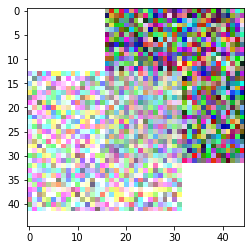

<AxesSubplot:>

In [190]:
# test merge with rasterio
import rasterio
import glob
from rasterio.merge import merge
from rasterio.plot import show

# https://automating-gis-processes.github.io/CSC18/lessons/L6/raster-mosaic.html
# merge :; https://rasterio.readthedocs.io/en/latest/api/rasterio.merge.html
# show :


def weighted_mean(
    old_data, new_data, old_nodata, new_nodata, index=None, roff=None, coff=None
):
#     # TODO DEBUG all nodata = 0 -> no nodata
#     old_nodata = np.zeros_like(old_nodata)
#     new_nodata = np.zeros_like(new_nodata)

    #     # weights at last dim -> change with a param
    #     old_data[:-1][old_nodata[:-1]] = np.nan
    #     new_data[:-1][new_nodata[:-1]] = np.nan

    weights_sum = np.zeros_like(old_data)

    for band_idx in range(len(old_data)):

        # scale the data with weights and ignore nodata
        old_data[band_idx] = (
            old_data[band_idx] * old_data[-1] * (1 - old_nodata[band_idx])
        )
        new_data[band_idx] = (
            new_data[band_idx] * new_data[-1] * (1 - new_nodata[band_idx])
        )

        # add weights to themselves if not nan
        w1 = old_data[-1] * (1 - old_nodata[band_idx])  # set contrib to zero if nodata
        w2 = new_data[-1] * (1 - new_nodata[band_idx])
        weights_sum[band_idx] = w1 + w2  # w1 + w2 at each location
    
    # we also do a weighted sum of weights !
    data_sum = np.nansum(
        [old_data, new_data], axis=0
    )  # nansum the two rasters -> (N,32,32) output
    average = data_sum / weights_sum
    average[np.isnan(average)] = NODATAVALUE
    np.clip(average, 0, 1, out=old_data)


a0 = f"./test_0.tif"
a1 = f"./test_1.tif"
dem_fps = [a0, a1]
src_files_to_mosaic = []
for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

mosaic, out_trans = merge(src_files_to_mosaic, method=weighted_mean)
show(mosaic)

In [191]:
# save to
out_fp = "./merged.tif"


# Copy the metadata
out_meta = src.meta.copy()

# Update the metadata
out_meta.update(
    {
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        #         "crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs ",
    }
)
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

In [187]:
mosaic.max()

0.0